# Installing Libraries

In [1]:
# TorchIO is a Python library for efficient 3D medical image preprocessing in PyTorch
!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 7.3 MB/s eta 0:00:00


In [2]:
#Torchsummary is a Python library providing model summary information for PyTorch models.
!pip install torchsummary

# Import Libraries

In [3]:
import time, tqdm, os, argparse, logging, sys, wandb; 
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import nibabel as nib
import torchio as tio

import tempfile

import torch
import torch.nn as nn
from torch.nn.functional import pad, sigmoid, binary_cross_entropy
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
    
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

import sklearn 
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import clear_output
%matplotlib inline

# Visualizing Images and dataset

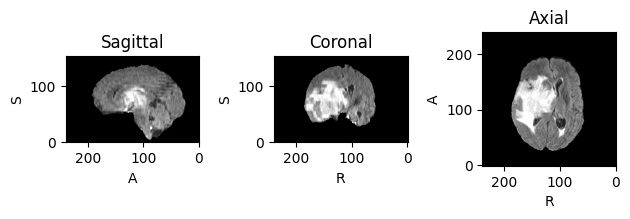

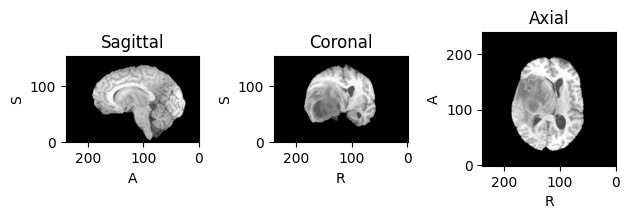

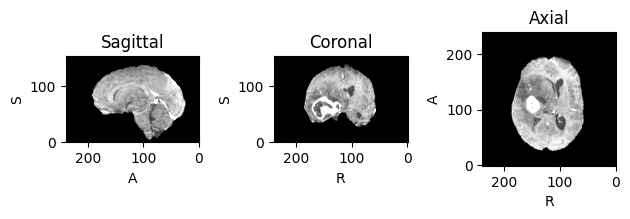

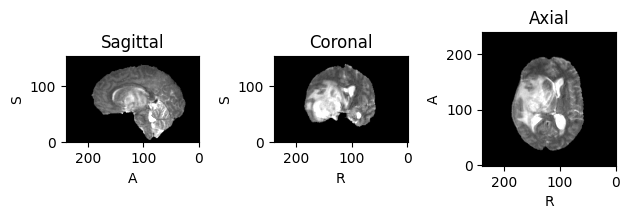

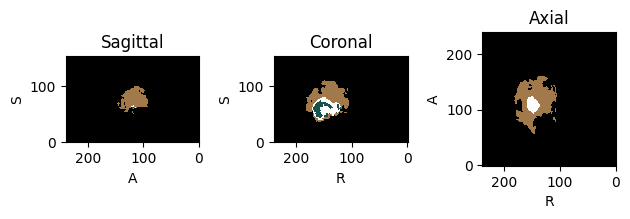

In [4]:
flair_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
t1_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
t1ce_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
t2_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'
seg_path = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'

# ScalarImage is used to represent grayscale images
# LabelMap is used to represent segmented images where each voxel is assigned a label

flair_img = tio.ScalarImage(flair_path)
t1_img = tio.ScalarImage(t1_path)
t1ce_img = tio.ScalarImage(t1ce_path)
t2_img = tio.ScalarImage(t2_path)
seg_img = tio.LabelMap(seg_path)

flair_img.plot()
t1_img.plot()
t1ce_img.plot()
t2_img.plot()
seg_img.plot()


In [5]:
df = pd.read_csv('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')
df.head()

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID,BraTS_2020_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1,BraTS20_Training_001
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1,BraTS20_Training_002
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1,BraTS20_Training_003
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1,BraTS20_Training_004
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1,BraTS20_Training_005


In [6]:
sur_info = pd.read_csv('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
sur_info.head()

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR


In [7]:
print(df['Grade'].unique())
print(sur_info['Extent_of_Resection'].unique())

['HGG' 'LGG']
['GTR' nan 'STR']


# Pre-processing Dataset

In [8]:
"""
Create class function for target path and seed random
"""
class GlobalConfig():
    root = '../input/brats20-dataset-training-validation/'
    train_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
    val_path = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
    name_mapping_path = 'name_mapping.csv'
    survival_info_path = 'survival_info.csv'
    train_df = 'train_df.csv'
    seed = 55
def SeedEveryThing(seed:int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = GlobalConfig()
SeedEveryThing(config.seed)


##### In this dataset of MICCAI_BraTS2020, it has two data files CSV so we need to merge them into one data frame to visualize and remove null data 

In [9]:
name_mapping = pd.read_csv(os.path.join(config.root, config.train_path + config.name_mapping_path))
survival_info = pd.read_csv(os.path.join(config.root, config.train_path + config.survival_info_path))
name_mapping.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis = 1, inplace = True)
df = survival_info.merge(name_mapping, on='Brats20ID', how='right')
path = []
for _, row in df.iterrows():
    id_ = row['Brats20ID']
    phase = id_.split('_')[-2]
    if phase == 'Training':
        data_path = os.path.join(config.root, config.train_path + id_)
    else:
        data_path = os.path.join(config.root, config.train_path + id_)
    path.append(data_path)
df['Path'] = path
df['Age_rank'] = df['Age'].values//10*10
df= df.loc[df['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop = True)
train_df = df.loc[df['Age'].isnull() != True].reset_index(drop = True)
skf = StratifiedKFold(n_splits=7, random_state=config.seed, shuffle = True)
for i, (train_index, val_index) in enumerate(skf.split(train_df, train_df['Age_rank'])):
    train_df.loc[val_index,['Fold']] = i
train_data = train_df.loc[train_df['Fold'] != 0.0].reset_index(drop=True)
val_data = train_df.loc[train_df['Fold'] == 0.0].reset_index(drop=True)
test_df = df.loc[df['Age'].isnull()].reset_index(drop=True)
train_df.to_csv(config.train_df, index = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Brats20ID              368 non-null    object 
 1   Age                    235 non-null    float64
 2   Survival_days          235 non-null    object 
 3   Extent_of_Resection    128 non-null    object 
 4   Grade                  368 non-null    object 
 5   BraTS_2017_subject_ID  285 non-null    object 
 6   BraTS_2018_subject_ID  285 non-null    object 
 7   TCGA_TCIA_subject_ID   167 non-null    object 
 8   BraTS_2019_subject_ID  335 non-null    object 
 9   Path                   368 non-null    object 
 10  Age_rank               235 non-null    float64
dtypes: float64(2), object(9)
memory usage: 31.8+ KB


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


In [10]:
# transformation is only applied when phase ==train i.e. when training mode is on augmentation is done then.
def get_transform(phase):
    if phase == 'train':
       # Applies random affine transformations (scaling, rotation, translation, shearing) 
       # to the images with a probability of 0.5.
        # ('LR' for left-right, 'AP' for anterior-posterior, 'IS' for inferior-superior)
        list_transforms = [
            tio.RandomAffine(p = 0.5),
            tio.RandomFlip(axes=['LR', 'AP', 'IS'], p = 0.25),
          # tio.RandomBlur(p = 0.25),
          #  tio.RandomNoise(p = 0.25),         
        ]
        # Transforms can also be composed as in torchvision.transforms
        transform = tio.Compose(list_transforms)
    else:
        list_transforms = []
        transform = tio.Compose(list_transforms)
    return transform

# Dataset 

In [11]:
class BratsDataSet(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str = 'test'):
        self.df = df
        self.phase = phase
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, index):
        id_ = self.df.loc[index, 'Brats20ID']
        data_path = self.df.loc[self.df['Brats20ID'] == id_]['Path'].values[0]
        data_img = []
        resample = tio.Resample((2,2,2))
#         normalize = tio.ZNormalization()
        for data_type in self.data_types:
            img = tio.ScalarImage(os.path.join(data_path, id_ + data_type)) #data_img shape (1, 240, 240, 155)
            img = resample(img) #data_img shape (1, 120, 120, 78)
#             img = normalize(img)
            img = np.array(img)
            img = np.squeeze(img, axis = 0)
            img = self.Normalize(img)
            data_img.append(img)
        img_stack = np.stack(data_img)
        img_stack = np.moveaxis(img_stack, (0,1,2,3), (0,3,2,1))
        img_stack = torch.Tensor(img_stack)
        
        if phase != 'test':
            labels = tio.LabelMap(os.path.join(data_path, id_ + '_seg.nii'))
            labels = resample(labels)
            labels = np.array(labels)
            labels = np.squeeze(labels, axis = 0)
            label_stack = self.ConvertToMultiChannel(labels)
            label_stack = torch.Tensor(label_stack)
            
            subjects = tio.Subject(image = tio.ScalarImage(tensor = img_stack),
                                   label = tio.LabelMap(tensor = (label_stack > 0.5)),
                                   id = id_
                                  )
            
            
            return subjects
        subjects = tio.Subject(image = tio.ScalarImage(tensor = img_stack),
                               id = id_
                              )
        return subjects
    
    def Normalize(self, image : np.ndarray):
        return (image - np.min(image))/(np.max(image) - np.min(image))
 
    def ConvertToMultiChannel(self, labels):
        '''
        Convert labels to multi channels based on brats classes:
        label 1 is the peritumoral edema
        label 2 is the GD-enhancing tumor
        label 3 is the necrotic and non-enhancing tumor core
        The possible classes are TC (Tumor core), WT (Whole tumor)
        and ET (Enhancing tumor)
        '''
        label_TC = labels.copy()
        label_TC[label_TC == 1] = 1
        label_TC[label_TC == 2] = 0
        label_TC[label_TC == 4] = 1
        
        
        label_WT = labels.copy()
        label_WT[label_WT == 1] = 1
        label_WT[label_WT == 2] = 1
        label_WT[label_WT == 4] = 1
        
        label_ET = labels.copy()
        label_ET[label_ET == 1] = 0
        label_ET[label_ET == 2] = 0
        label_ET[label_ET == 4] = 1
        
        label_stack = np.stack([label_WT, label_TC, label_ET])
        label_stack = np.moveaxis(label_stack, (0,1,2,3), (0,3,2,1))
        return label_stack

In [12]:
def get_dataloader(dataset, path_to_csv, phase, fold = 0, batch_size = 1, num_workers = 4):
    """
    This  function is saving image data in to the list and putting it with torchio.SubjectDataSet
    to split and transform image
    """
    start_time = time.time()
    data = pd.read_csv(path_to_csv)
    train_data = data.loc[data['Fold'] != fold].reset_index(drop = True)
    val_data = data.loc[data['Fold'] == fold].reset_index(drop = True)
    if phase == 'train':
        data = train_data
    else:
        data = val_data
    data_set = dataset(data, phase)
    list_subjects = []
    for i in range(len(data_set)):
        list_subjects.append(data_set[i])
    subject_dataset = tio.SubjectsDataset(list_subjects, transform=get_transform(phase))
    patch_size = 50
    queue_length = 300
    sample_per_volume = 1
    sampler = tio.data.UniformSampler(patch_size)
    patches_queue = tio.Queue(
        subject_dataset,
        queue_length,
        sample_per_volume,
        sampler,
        num_workers=num_workers,
    )
    data_loader = DataLoader(patches_queue,
                             batch_size = batch_size,
                             num_workers=0,
                             pin_memory=True,
                            )
    return data_loader

# LOSSES

### Dice Loss

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth = 1):
        # Commnent out if your model contains a sigmoid or equivalent activation layer
        inputs = sigmoid(inputs)
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum()+ targets.sum() + smooth)
        return 1 - dice

In [14]:
def dice_coef_metric(inputs: torch.Tensor, target: torch.Tensor, threshold: float = 0.5, eps:float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch,
    Params:
        inputs: model outputs after activation function
        target: true values
        threshold: threshold for inputs
        eps: additive to refine the estimate
    Return: dice score 
    """
    score = []
    num = inputs.shape[0]
    predictions = (inputs >= threshold).float()
    assert(predictions.shape == target.shape)
    for i in range(num):
        predict = predictions[i]
        target_ = target[i]
        intersection = 2.0*(target_*predict).sum()
        union = target_.sum() + predict.sum()
        if target_.sum() == 0 and predict.sum() == 0:
            score.append(1.0)
        else:
            score.append((intersection + eps)/union)
    return np.mean(score)

In [15]:
def dice_coef_metric_class(inputs, targets, threshold=0.5, eps:float=1e-9,classes = ['WT, TC', 'ET']):
    """ calculate dice scores for each class"""
    scores = {key:list for key in classes}
    num = inputs.shape[0]
    num_classes = inputs.shape[1]
    predictions = (inputs>=threshold).astype(np.float32)
    assert(prediction.shape == target.shape)
    for i in range(num):
        for class_ in classes:
            prediction = predictions[i][class_]
            target_ = target[i][class_]
            intersection = 2.0 * (prediction * prediction).sum()
            union = target_.sum() + prediction.sum()
            if target.sum() == 0 and prediction.sum() == 0:
                scores[classes][class_].append(1.0)
            else:
                scores[classes][class_].append((intersection+eps)/(union))
    return scores

## Jaccard/Intersection over Union (IoU) Loss

In [16]:
class IoU(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(IoU, self).__init__()
    def forward(self, inputs, target, smooth = 1):
        inputs = sigmoid(inputs)
        
        # Flatten labels and predict
        inputs = inputs.view(-1)
        target = target.view(-1)
        
        interection = (inputs*target).sum()
        total = (inputs + target).sum()
        union = total - interection
        
        IoU = (interection + smooth)/ (union + smooth)
        return 1 - IoU

In [17]:
def jaccard_coef_metric(inputs: torch.Tensor, target: torch.Tensor, threshold: float = 0.5, eps: float = 1e-9):
    scores = []
    num = inputs.shape[0]
    predictions = (inputs >= threshold).float()
    assert(predictions.shape == target.shape)
    for i in range(num):
        prediction = predictions[i]
        target_ = target[i]
        intersection = (prediction * target_).sum()
        union = (prediction.sum() + target_.sum()) - (intersection + eps)
        
        if target_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps)/union)
    return np.mean(scores)

In [18]:
def jarccard_coef_classes(inputs, target, theshold:float = 0.5, eps: float = (1e-9), classes = ['WT', 'TC', 'ET']):
    scores = []
    num = inputs.shape[1]
    predictions = (inputs >= threshold).astype(np.float32)
    for i in range(num):
        for class_ in classes:
            prediction = predictions[i][class_]
            target_ = target[i][class_]
            intersection = (prediction*target_).sum()
            union = (target_.sum() + prediction.sum()) - intersection
            assert(prediction.sum() == target_.sum())
            
            if prediction.sum() == 0 and target_.sum() == 0:
                scores[classes][class_].append(1.0)
            else:
                scores[classes][class_].append((intersection+eps)/uniom)
    return scores

# BCE-DICE LOSS

In [19]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight = None, size_average = True):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    def forward(self, inputs, targets, smooth = 1):
        assert(inputs.shape == targets.shape)
        dice_loss = self.dice(inputs, targets)
        bce_loss = self.bce(inputs, targets)
        return  dice_loss + bce_loss

In [20]:
class Scores:
    def __init__(self, threshold: float=0.5):
        self.threshold = threshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    def update(self, logits: torch.Tensor, target: torch.Tensor):
        inputs = torch.sigmoid(logits)
        dice = dice_coef_metric(inputs, target, self.threshold)
        iou = jaccard_coef_metric(inputs, target, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    def get_metrics(self):
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

## Focal Loss

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

## Tversky Loss

In [22]:
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.5, beta=0.5):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

## Focal Tversky Loss¶

In [23]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.7, beta=0.3, gamma=4/3):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

# MODEL

## UNET 3D

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        x = self.double_conv(x)
        return x

In [25]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        x = self.encoder(x)
        return x

In [26]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Make sure size data when you combine are the same size
        diffX = x2.size()[4] - x1.size()[4]
        diffY = x2.size()[3] - x1.size()[3]
        diffZ = x2.size()[2] - x1.size()[2]
        
        x1 = torch.nn.functional.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [27]:
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.out_conv(x)

In [38]:
'''
                            UNET 3D
        1|->|->|---------------------------->|->|->|1

              2|->|->|---------------->|->|->|2

                    3|->|->|---->|->|->|3     

                          4|->|->|4
'''
class UNET3D(nn.Module):
    def __init__(self, in_channels, out_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_classes = n_classes
        
        self.double_conv = DoubleConv(self.in_channels, self.out_channels)
        # encoder downsamplers
        self.down_1 = Down(self.out_channels, self.out_channels*2)
        self.down_2 = Down(self.out_channels*2, self.out_channels*4)
        self.down_3 = Down(self.out_channels*4, self.out_channels*8)
        self.down_4 = Down(self.out_channels*8, self.out_channels*16)

        # decoder upsamplers
        self.up_4 = Up(self.out_channels*16, self.out_channels*8)
        self.up_3 = Up(self.out_channels*8, self.out_channels*4)
        self.up_2 = Up(self.out_channels*4, self.out_channels*2)
        self.up_1 = Up(self.out_channels*2, self.out_channels)

        # output
        self.out = Out(self.out_channels, self.n_classes)
        
        self.dropout = nn.Dropout3d(0.5)
    def forward(self, x):
        # Encoder
        en_1 = self.double_conv(x)
#         en_1 = self.dropout(en_1)
        en_2 = self.down_1(en_1)
        en_2 = self.dropout(en_2)
        en_3 = self.down_2(en_2)
#         en_3 = self.dropout(en_3)
        en_4 = self.down_3(en_3)
        en_4 = self.dropout(en_4)
        en_5 = self.down_4(en_4)
#         en_5 = self.dropout(en_5)
        
        # Decoder
        de_4 = self.up_4(en_5, en_4)
        #print(de_4.shape)
        de_4 = self.dropout(de_4)
        de_3 = self.up_3(de_4, en_3)
#         de_3 = self.dropout(de_3)
        de_2 = self.up_2(de_3, en_2)
        de_2 = self.dropout(de_2)
        de_1 = self.up_1(de_2, en_1)
#         de_1 = self.dropout(de_1)
        
        out = self.out(de_1)
        return out

In [39]:
model_1 = UNET3D(in_channels=4, out_channels=64, n_classes=3).to('cuda')
summary(model_1, (4, 50, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 50, 50, 50]           6,976
       BatchNorm3d-2       [-1, 64, 50, 50, 50]             128
              ReLU-3       [-1, 64, 50, 50, 50]               0
            Conv3d-4       [-1, 64, 50, 50, 50]         110,656
       BatchNorm3d-5       [-1, 64, 50, 50, 50]             128
              ReLU-6       [-1, 64, 50, 50, 50]               0
        DoubleConv-7       [-1, 64, 50, 50, 50]               0
         MaxPool3d-8       [-1, 64, 25, 25, 25]               0
            Conv3d-9      [-1, 128, 25, 25, 25]         221,312
      BatchNorm3d-10      [-1, 128, 25, 25, 25]             256
             ReLU-11      [-1, 128, 25, 25, 25]               0
           Conv3d-12      [-1, 128, 25, 25, 25]         442,496
      BatchNorm3d-13      [-1, 128, 25, 25, 25]             256
             ReLU-14      [-1, 128, 25,

In [42]:
class Training:
    def __init__(self,
                 model: nn.Module,
                 dataset : Dataset,
                 criterion: nn.Module,
                 lr: float,
                 num_epochs: int,
                 batch_size: int,
                 path_to_csv: str,
                 fold: int,
                 accumulation_steps: int,
                 save_model_history: bool=True,
                 display_plot: bool= True
                ):
        # 1.Setup criterion and optimizer
        self.device =  'cuda' if torch.cuda.is_available() else 'cpu'
        print('Training on', self.device)
        self.model = model.to(self.device)
        self.dataset = dataset
        self.criterion = criterion
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                                    mode='min',
                                                                    factor=0.75,
                                                                    patience= 5,
                                                                    verbose=True,
                                                                   )
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.accumulation_steps = accumulation_steps
        # 2. Setup dataset
        self.phases = ['train', 'val']
        self.dataloaders = {phase: get_dataloader(self.dataset,
                                                  path_to_csv=path_to_csv,
                                                  phase=phase,
                                                  fold=fold,
                                                  batch_size=self.batch_size,
                                                  num_workers=4
                                                 )for phase in self.phases}
        # 3. Setup loss and plot
        self.best_loss = float('inf')
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.save_model_history = save_model_history
        self.display_plot = display_plot
    
    def run(self):
        for epoch in range(self.num_epochs):
            self.one_epoch(epoch, 'train')
            with torch.no_grad():
                val_loss = self.one_epoch(epoch, 'val')
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print(f'Saved new checkpoint')
                self.best_loss = val_loss
                torch.save(self.model.state_dict(), f'best_checkpoint.pt')
            print('-------------------------------')
        if self.display_plot:
            self.plot_history()
        if self.save_model_history:
            self.save_history()
                
    def one_epoch(self, epoch: int, phase: str):
        print(f'{phase} epoch: {epoch}')
        self.model.train() if phase == 'train' else self.model.eval()
        scores = Scores()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for i, data in enumerate(dataloader):
            images = data['image'][tio.DATA].to(self.device)
            targets = data['label'][tio.DATA].to(self.device)
            
            # Controlled debug print to trace unwanted output
            #if i == 0:  # Only print the first batch to trace the issue
                #print(f"Debug: Image shape {images.shape}, Target shape {targets.shape}")
            
            predict = self.model(images)
            loss = criterion(predict, targets.float())
            loss = loss/self.accumulation_steps
            if phase == 'train':
                loss.backward()
                if (i + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            scores.update(predict.detach().cpu(),
                          targets.detach().cpu()
                         )
        epoch_loss = (running_loss * self.accumulation_steps)/total_batches
        epoch_dice, epoch_iou = scores.get_metrics()
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.iou_scores[phase].append(epoch_iou)
        print(f'loss: {epoch_loss:.3f} dice: {epoch_dice:.3f} iou: {epoch_iou:.3f}')
        return epoch_loss
    
    def save_history(self):
        torch.save({
                'epoch': self.num_epochs,
                'model_state_dict': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'loss': self.losses['train'][-1]
                }, f'last_checkpoint.pt')
        print('Saved check point')
        logs_ = [self.losses, self.dice_scores, self.iou_scores]
        log_name_ = ['_loss', '_dice', '_iou']
        logs = [logs_[i][key] for i in range(len(logs_)) for key in logs_[i]]
        log_names = [key + log_name_[i] for i in range(len(logs_)) for key in logs_[i]]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv('train_log.csv', index=False)
    
    def load_predtrain_model(self, pred_path:str):
        self.model.load_state_dict(torch.load(pred_path))
        print('Predtrain model loaded')
    
    def plot_history(self):
        data = [self.losses, self.dice_scores, self.iou_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.iou_scores['train'][-1]}
            val jaccard score {self.iou_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()

In [44]:
model = model_1
dataset=BratsDataSet
criterion=FocalTverskyLoss()
lr=3e-4
num_epochs=100
batch_size = 5
path_to_csv=config.train_df
fold=0
accumulation_steps=4
save_model_history=True
display_plot=True

trainer=Training(model=model,
                 dataset=dataset,
                 criterion=criterion,
                 lr=lr,
                 num_epochs=num_epochs,
                 batch_size=batch_size,
                 path_to_csv=path_to_csv,
                 fold=fold,
                 accumulation_steps=accumulation_steps,
                 save_model_history=save_model_history,
                 display_plot=display_plot
                )

Training on cuda


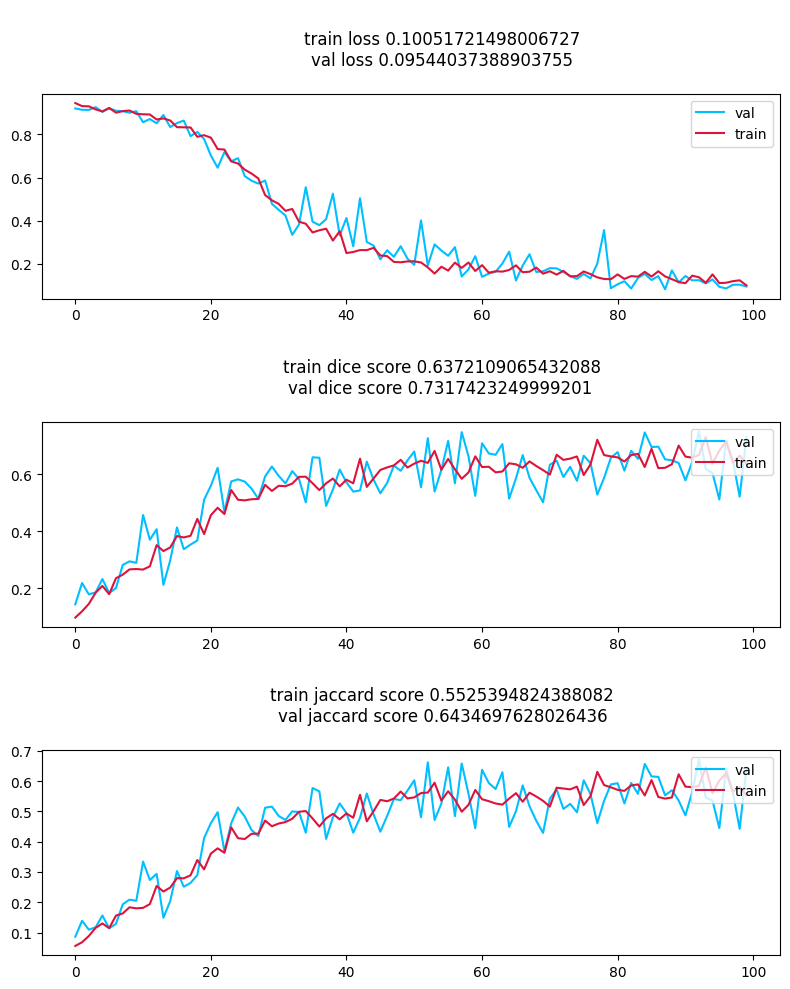

Saved check point


In [45]:
trainer.run()

In [46]:
def get_dataloader(dataset, path_to_csv, phase, fold = 0, batch_size = 1, num_workers = 4):
    """
    This  function is saving image data in to the list and putting it with torchio.SubjectDataSet
    to split and transform image
    """
    start_time = time.time()
    data = pd.read_csv(path_to_csv)
    train_data = data.loc[data['Fold'] != fold].reset_index(drop = True)
    val_data = data.loc[data['Fold'] == fold].reset_index(drop = True)
    if phase == 'train':
        data = train_data
    else:
        data = val_data
    data_set = dataset(data, phase)
    list_subjects = []
    for i in range(len(data_set)):
        list_subjects.append(data_set[i])
    subject_dataset = tio.SubjectsDataset(list_subjects, transform=get_transform(phase))
    data_loader = DataLoader(subject_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             pin_memory=True,
                             shuffle=True, 
                            )
    return data_loader

In [47]:
dataloader = get_dataloader(dataset=BratsDataSet, path_to_csv=config.train_df, phase='valid', fold=0)
len(dataloader)

34

In [52]:
# Assuming `dataloader` is your PyTorch DataLoader instance
data = next(iter(dataloader))

# Accessing information from the batch
ids = data['id']  # Assuming 'id' is a key in your batch dictionary
image_shape = data['image'][tio.DATA].shape  # Assuming 'image' is a key containing image data
label_shape = data['label'][tio.DATA].shape  # Assuming 'label' is a key containing label data

# Printing the retrieved information
print("IDs:", ids)
print("Image shape:", image_shape)
print("Label shape:", label_shape)


IDs: ['BraTS20_Training_024']
Image shape: torch.Size([1, 4, 78, 120, 120])
Label shape: torch.Size([1, 3, 78, 120, 120])


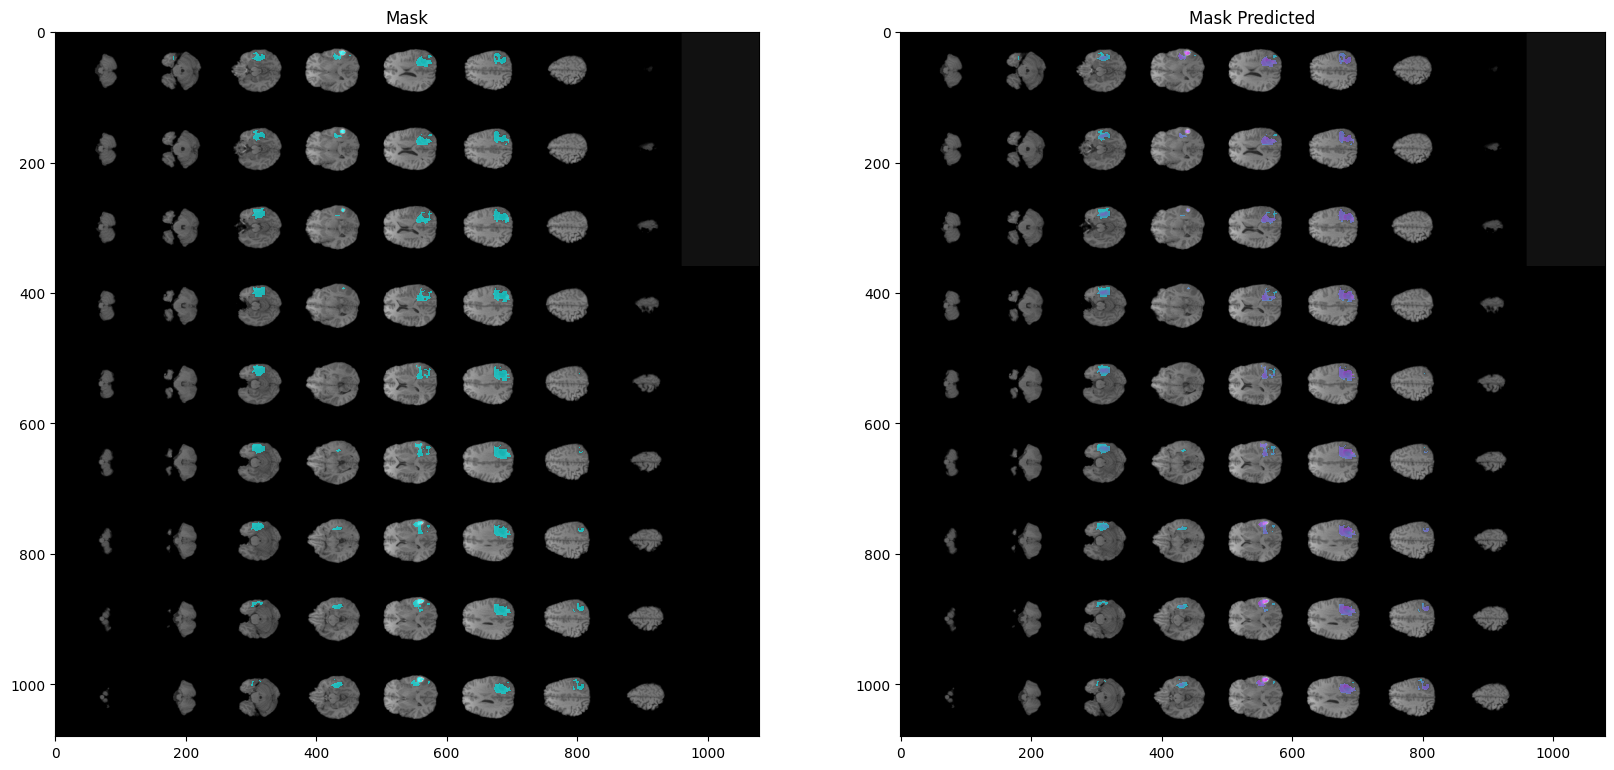

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
    images = data['image'][tio.DATA].to(device)
    targets = data['label'][tio.DATA].to(device)
    predict = model(images)
    
    # Prepare tensors for visualization
    img_tensor = data['image'][tio.DATA].squeeze()[1].cpu().detach().numpy() 
    mask_tensor = data['label'][tio.DATA].squeeze()[0].squeeze().cpu().detach().numpy()
    predict_tensor = predict.squeeze()[0].squeeze().cpu().detach().numpy()
    
    # Create montages and rotate them
    image = np.rot90(montage(img_tensor))
    mask = np.rot90(montage(mask_tensor))
    mask_predict = np.rot90(montage(predict_tensor))
    
    # Plot the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
    ax1.imshow(image, cmap='gray')
    ax1.imshow(np.ma.masked_where(mask == False, mask), cmap='cool', alpha=0.6)
    ax1.set_title('Mask')  # Title for the actual mask
    
    ax2.imshow(image, cmap='gray')
    ax2.imshow(np.ma.masked_where(mask == False, mask_predict), cmap='cool', alpha=0.6)
    ax2.set_title('Mask Predicted')  # Title for the predicted mask

    plt.show()


In [54]:
# Assuming `dataloader` is your PyTorch DataLoader instance
data = next(iter(dataloader))

# Accessing information from the batch
ids = data['id']  # Assuming 'id' is a key in your batch dictionary
image_shape = data['image'][tio.DATA].shape  # Assuming 'image' is a key containing image data
label_shape = data['label'][tio.DATA].shape  # Assuming 'label' is a key containing label data

# Printing the retrieved information
print("IDs:", ids)
print("Image shape:", image_shape)
print("Label shape:", label_shape)


IDs: ['BraTS20_Training_230']
Image shape: torch.Size([1, 4, 78, 120, 120])
Label shape: torch.Size([1, 3, 78, 120, 120])


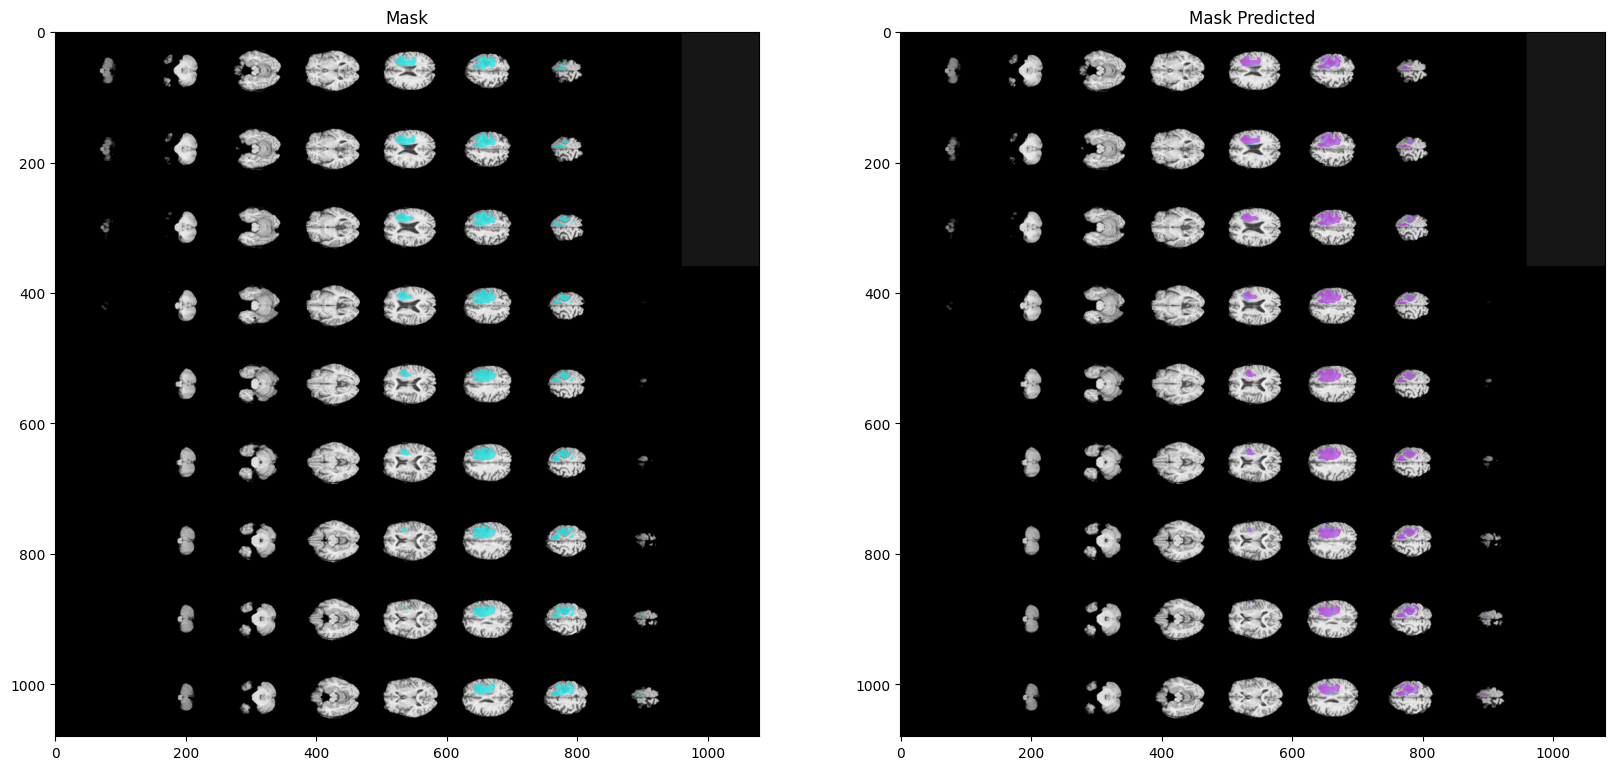

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
    images = data['image'][tio.DATA].to(device)
    targets = data['label'][tio.DATA].to(device)
    predict = model(images)
    
    # Prepare tensors for visualization
    img_tensor = data['image'][tio.DATA].squeeze()[1].cpu().detach().numpy() 
    mask_tensor = data['label'][tio.DATA].squeeze()[0].squeeze().cpu().detach().numpy()
    predict_tensor = predict.squeeze()[0].squeeze().cpu().detach().numpy()
    
    # Create montages and rotate them
    image = np.rot90(montage(img_tensor))
    mask = np.rot90(montage(mask_tensor))
    mask_predict = np.rot90(montage(predict_tensor))
    
    # Plot the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
    ax1.imshow(image, cmap='gray')
    ax1.imshow(np.ma.masked_where(mask == False, mask), cmap='cool', alpha=0.6)
    ax1.set_title('Mask')  # Title for the actual mask
    
    ax2.imshow(image, cmap='gray')
    ax2.imshow(np.ma.masked_where(mask == False, mask_predict), cmap='cool', alpha=0.6)
    ax2.set_title('Mask Predicted')  # Title for the predicted mask

    plt.show()
